# Lab 7: Recommendation Systems and collaborative filtering

We'll build our X and Y matrixes to pass them though a Adam model

In [1]:
import numpy as np
import pandas as pd
import re
import functions as assets
import matplotlib.pyplot as plt


In [2]:
import seaborn as sns
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')

In [3]:
# manipulate our dataframes to get the ideal schema for matrix X
links_small = pd.read_csv('links_small.csv')
ratings = pd.read_csv('ratings_small.csv')
user_ratings = links_small.merge(ratings, how='left', on='movieId')
user_ratings.drop(['timestamp'], inplace=True, axis=1)
user_ratings['rating'].fillna(0, inplace=True)
user_ratings['rating'] = user_ratings['rating'].astype(int)
user_ratings.dropna(inplace=True, subset=['userId'])

## User rating (X) matrix

In [4]:
user_ratings.head(3)


,movieId,imdbId,tmdbId,userId,rating
0,1,114709,862.0,7.0,3
1,1,114709,862.0,9.0,4
2,1,114709,862.0,13.0,5


We'll manipulate it to have the ideal dimensions later

## Movie feature (Y) matrix

In [5]:
# load Y matrix (features by movie)
movies_meta = pd.read_csv('movies_metadata.csv')
movies_md = movies_meta[['genres', 'id', 'imdb_id']]
movies_md.shape

(45466, 3)

In [6]:
movies_md.head(3)

,genres,id,imdb_id
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228


In [7]:
# manipulate to have the ideal schema for matrix Y
works_data = pd.DataFrame(movies_md.genres.str.split(',').tolist(), index=movies_md.id).stack()
works_data = works_data.reset_index([0, 'id'])
works_data.columns = ['id', 'value']
works_data['id_genre'] = works_data.value.str.extract("{'id': (\d+)", expand=False)
works_data.drop(['value'], axis=1, inplace=True)
works_data.dropna(inplace=True)

In [8]:
works_data.head(3)

,id,id_genre
0,862,16
2,862,35
4,862,10751


In [9]:
# concat both dataframes to have organized indexes, as well as connected data and equal movies by row between both matrixes
df = pd.concat([works_data, user_ratings], axis = 1)
df.dropna(inplace=True) 
df.drop_duplicates(subset=['tmdbId'], inplace=True)
df['ones'] = np.ones(df.shape[0])


In [10]:
# build Y datafame (features by movie)
ye = df.pivot_table(index='tmdbId', columns='id_genre', values='ones', fill_value=0)
ye.head(3)

id_genre,10402,10749,10751,10752,10769,10770,12,14,16,18,27,28,35,36,37,53,80,878,9648,99
tmdbId,,,,,,,,,,,,,,,,,,,,
2.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Y dataframe to array
y = ye.to_numpy()
y.shape

(7483, 20)

In [12]:
# build X dataframe (ratings of users by movie)
equis = df.pivot_table(index='tmdbId', columns='userId', values='rating', fill_value=0)
equis.head(3)

userId,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,652.0,654.0,655.0,656.0,659.0,660.0,663.0,664.0,665.0,668.0
tmdbId,,,,,,,,,,,,,,,,,,,,,
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# X dataframe to array
x = equis.to_numpy()
x.shape

(7483, 425)

All of these transformations helped us to have ideal dimensions and structured connections between matrixes

## Apply Adam model

In this stage we're going to try two models: X matrix with degree 1 and X matrix with degree 2

In [14]:
# X matrix: rows are movies and columns are features. Y matrix: rows are movies and columns are users
n, m = x.shape
f = y.shape[1]
theta_0 = np.random.rand(f, m)

Split data in train, test and cv

In [15]:
# 70% train, 15% test, 15% cv
X_train, X_test, X_cv = x[0:5238], x[5239:6360], x[6361:7482]
y_train, y_test, y_cv = y[0:5238], y[5239:6360], y[6361:7482]

### Model 1

In this model we're going to try the default values for every function and normal configurations for every slice of the data

In [16]:
X_f, T_f, cost1 = assets.adam(y_train, X_train, theta_0, assets.cost, assets.gradient)

In [17]:
# costs
cost_train = cost1[-1]
test_cost = assets.cost(y_test, X_test, T_f)
cv_cost = assets.cost(y_cv, X_cv, T_f)

print(f'Train cost: {cost_train}, test cost: {test_cost}, cv cost: {cv_cost}')

Train cost: 7.627052358322776e-28, test cost: 1723.548196361271, cv cost: 1326.7484555912047


Text(0.5, 1.0, 'Cost decrease by iterations, model 1 (train)')

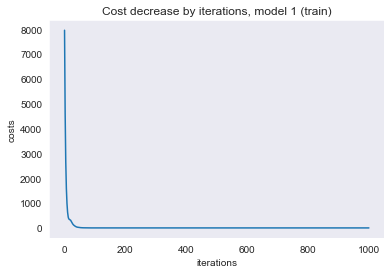

In [18]:
data = pd.DataFrame({'costs': cost1, 'iterations': np.arange(len(cost1))})
sns.lineplot(data=data, x="iterations", y="costs").set_title('Cost decrease by iterations, model 1 (train)')

Text(0.5, 1.0, 'Cost comparison between train, test and cv, model 1')

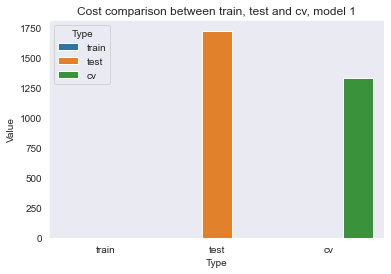

In [19]:
data = pd.DataFrame([['train', cost_train], ['test', test_cost], ['cv', cv_cost]], columns=['Type', 'Value'])
sns.barplot(x='Type', y='Value', hue="Type", data=data).set_title('Cost comparison between train, test and cv, model 1')

Model 2

In [20]:
X_f2, T_f2, cost2 = assets.adam(y_train, X_train ** 2, theta_0, assets.cost, assets.gradient)

In [21]:
# costs
cost_train2 = cost2[-1]
test_cost2 = assets.cost(y_test, X_test ** 2, T_f2)
cv_cost2 = assets.cost(y_cv, X_cv ** 2, T_f2)

print(f'Train cost: {cost_train2}, test cost: {test_cost2}, cv cost: {cv_cost2}')

Train cost: 0.011492026280813786, test cost: 52525.26034949419, cv cost: 42338.29842188493


Text(0.5, 1.0, 'Cost decrease by iterations, model 2 (train)')

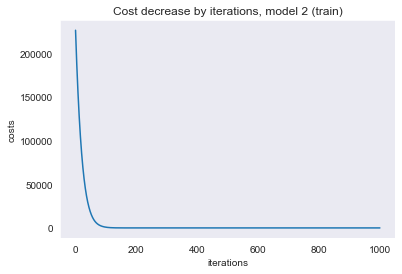

In [22]:
data2 = pd.DataFrame({'costs': cost2, 'iterations': np.arange(len(cost2))})
sns.set_style("dark")
sns.lineplot(data=data2, x="iterations", y="costs").set_title('Cost decrease by iterations, model 2 (train)')

Text(0.5, 1.0, 'Cost comparison between train, test and cv, model 2')

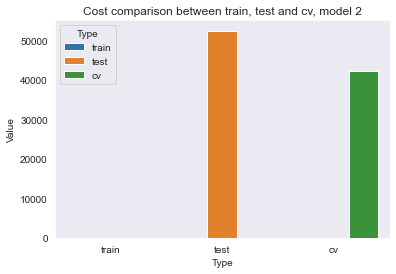

In [23]:
data2 = pd.DataFrame([['train', cost_train2], ['test', test_cost2], ['cv', cv_cost2]], columns=['Type', 'Value'])
sns.barplot(x='Type', y='Value', hue="Type", data=data2).set_title('Cost comparison between train, test and cv, model 2')

## Conclusion

Both of our models had similar results between train, test and cv costs. ** Model 1 ** has better performance with a very low train cost but a high test and cv cost

I think these answers have this bias of costs due to the configuration of variables in the adam function itself, but those values weren't supposed to be changed for the scope of this work